# GAN implication for practice

## MINST

In [21]:
import torch
from torch import nn, optim
# Variable provides a wrapper around tensors to allow automatic differentiation, etc.
from torch.autograd.variable import Variable 
from torchvision import transforms, datasets

import matplotlib.pyplot as plt

In [22]:
def load_mnist_data():
    compose = transforms.Compose([ # 'compose' several transforms together
        transforms.ToTensor(),
        transforms.Normalize((.5,.5,.5),(.5,.5,.5)) # normalize by mean and std per channel
        #TODO: This seems less than ideal, because values more extreme than -1/1 are possible?
    ])
    out_dir='./dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True) # download and transform data

In [23]:
data = load_mnist_data()

In [24]:
num_batches = 128
data_loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)

In [25]:
def images_to_vectors(images):
    # TODO: What module is the view from?
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [26]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super().__init__() # get the __init__() from the parent module
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024), # Linear transformation part input*W+b
            nn.LeakyReLU(0.2), # leaky relu is more robust for GANs than ReLU
            nn.Dropout(0.3)
            )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512), # Linear transformation part input*W+b
            nn.LeakyReLU(0.2), # leaky relu is more robust for GANs than ReLU
            nn.Dropout(0.3)
            )
            
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256), # Linear transformation part input*W+b
            nn.LeakyReLU(0.2), # leaky relu is more robust for GANs than ReLU
            nn.Dropout(0.3)
        )
        
        self.out = nn.Sequential(
            nn.Linear(256, n_out), # Linear transformation part input*W+b
            nn.Sigmoid()
        )
    
    # Careful to make forward() a function of the net, not of __init__
    def forward(self, x):
        # TODO: There must be a more concise way to build the network from the layers
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
        
discriminator = DiscriminatorNet()
            

In [27]:
class GeneratorNet(torch.nn.Module):
    """
    A three-layer generative neural network
    """
    def __init__(self):
        super().__init__()
        n_features = 100
        # TODO: Why 100 random input numbers? 
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
            # TODO: Why no dropout in generator?
        )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
        
generator = GeneratorNet()

In [28]:
def make_noise(size):
    """
    Generates a vector with length 100 of Gaussian noise with (batch_size, 100)
    """
    n = Variable(
        torch.randn(size, 100) # random values from standard normal
    )
    return n

### Optimizers

In [29]:
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [30]:
loss = nn.BCELoss() # Binary Cross Entropy Loss

The binary cross-entropy loss is defined in pytorch as:
$$ - w_i ( y_i\log p_i + (1-y_i) \log(1-p_i) )$$
and we treat all observations equally, so $w_i=1  \forall i$. For the usual $0 \leq p \leq 1$, this will be a positive number. The higher the entropy, the worse our predictionss, so we typically want to minimize it. 

### Auxiliary target variable

In [31]:
def ones_target(size):
    """
    Tensor containing ones, with shape = size
    """
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    """
    Tensor containing ones, with shape = size
    """
    data = Variable(torch.zeros(size, 1))
    return data

Discriminator should output 1 if data is real and 0 if it is fake. The target variable is created on-the-fly for the real and fake data.

In [32]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0) # Get number of rows from torch tensor
    optimizer.zero_grad() # reset gradient
    
    # Note: Calling backward() multiple times will acumulate the gradients
    # until they are reset with zero_grad()
    # real data loss + gradient
    prediction_real = discriminator(real_data)
    loss_real = loss(prediction_real, ones_target(N))
    loss_real.backward()
    
    # train on fake data
    prediction_fake = discriminator(fake_data)
    loss_fake = loss(prediction_fake, zeros_target(N))
    loss_fake.backward()
    
    # Weight update
    optimizer.step()
    
    # Return error and predictions for monitoring
    return loss_real + loss_fake, prediction_real, prediction_fake

The generator loss increases when the discriminator predicts 0 for the fake data. We want 
$$ (1-y_i) \min \log (1-D(G(z_i)) $$ where $y_i=0, \forall y_i$ for our fake data, so
$$ \min \log (1-D(G(z_i)). $$

That minimization is equivalent to 
$$ \min \exp \log (1-D(G(z_i)) = \min 1-D(G(z_i) $$
because $\exp$ is a monotonic transformation.

We can drop the constant 1, again because of monotonicity, to get 
$$ \min -D(G(z_i) = \max D(G(z_i) $$ or $$\max \log D(G(z_i)) = \min -\log D(G(z_i)).$$

We can hack the BCE loss by setting $y_i = 1 \forall y$ to get only the first part of the loss
$$ -y\log(p)$$ with $p = D(G(z_i))$ and $y=1$, which we then minimize. 

In [33]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0) # Get number of rows from torch tensor
    optimizer.zero_grad() # reset gradient
    
    # Get discriminator prediction output
    discriminator_prediction = discriminator(fake_data)
    
    # See explanation above. Intuitively, we create loss if the 
    # discriminator predicts our pseudo-ones as zeros.
    loss_generator = loss(discriminator_prediction, ones_target(N))
    loss_generator.backward()
    
    # Weight update
    optimizer.step()
    
    # Return error and predictions for monitoring
    return loss_generator

### Training

In [34]:
validation_noise = make_noise(1)

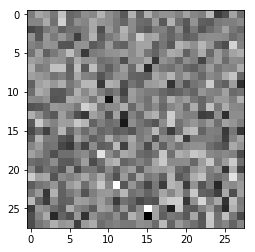

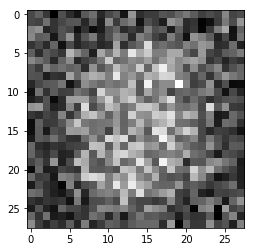

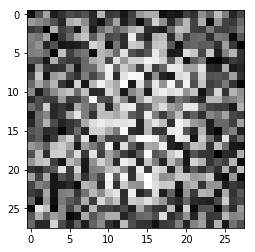

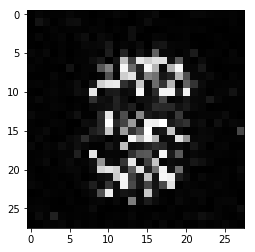

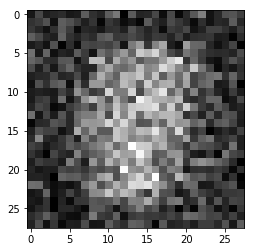

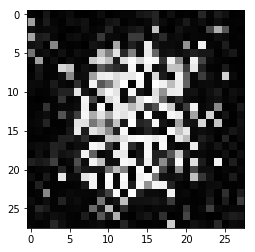

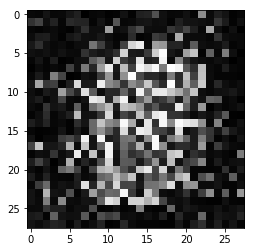

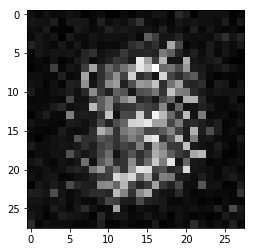

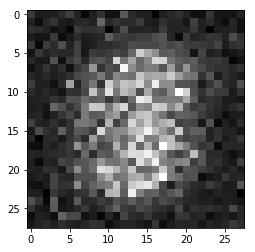

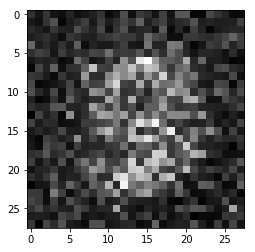

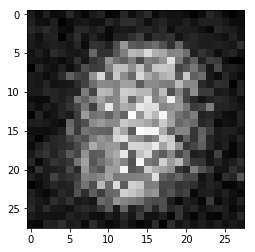

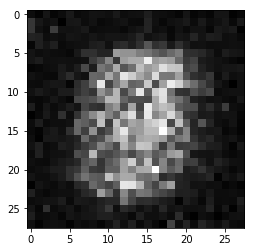

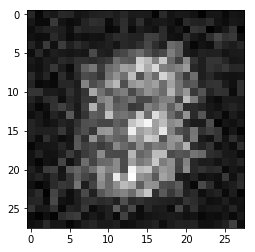

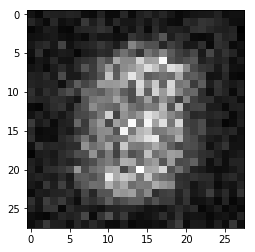

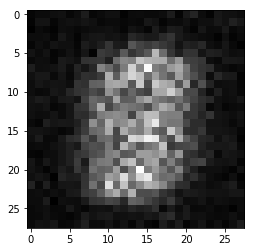

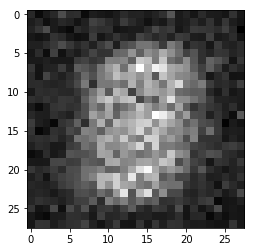

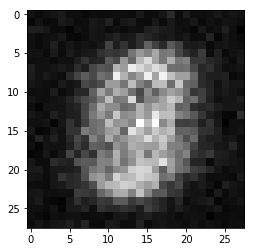

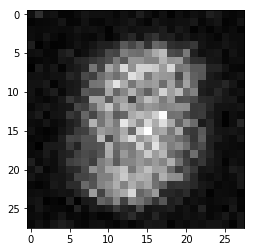

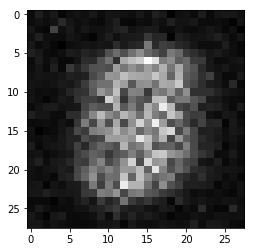

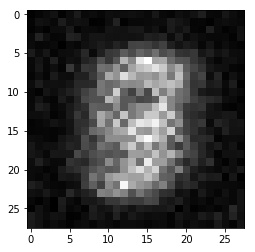

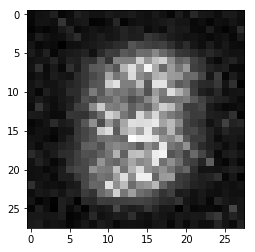

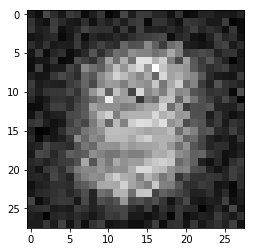

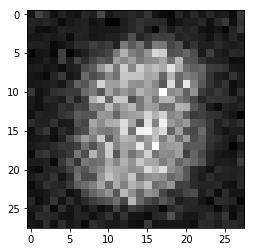

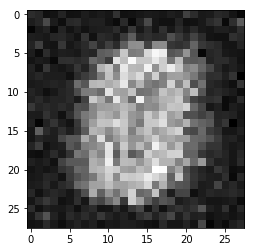

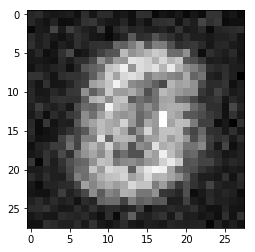

KeyboardInterrupt: 

In [35]:
num_epochs = 10

for epoch in range(num_epochs):
    # enumerate() outputs index, value for an indexable object
    # output the index of the batch and the output of data_loader
    # data_loader() outputs a batch of images and their label (which we don't need in this case)
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0) # Get the number of images from tensor
        
        ## Train discriminator
        # Collect real data
        real_data = Variable(images_to_vectors(real_batch))
        # Create fake data
        fake_data = generator(make_noise(N)).detach() 
        # generator() creates a graph on the fly, which we drop after collecting the fake data
        
        disc_error, disc_pred_real, disc_pred_fake = train_discriminator(discriminator_optimizer, real_data, fake_data)
        
        ## Train generator
        fake_data = generator(make_noise(N))
        # This time we keep the graph, because we to backprop on it in the training function
        gen_error = train_generator(generator_optimizer, fake_data)
        
        if n_batch % 100 ==0:
            test_images = vectors_to_images(generator(validation_noise))
            test_images = test_images.data # Get values from pytorch tensor
            
            plt.imshow(test_images.reshape(28,28), cmap='gray')
            plt.show()
        

## Tabular data

In [95]:
import numpy as np
import pandas as pd

In [99]:
datatable = np.column_stack([
 np.random.normal(10,2,size=[1000,]),
 np.random.poisson(lam=5.,size=[1000,]), # Integer output
 np.random.binomial(1,p=0.7,size=[1000,]), # Binary output
 np.random.binomial(1,p=0.7,size=[1000,]), # Conditional synthetic data
 np.random.multinomial(1,pvals=[0.1,0.4,0.5], size=1000), # Multiclass output
])
datatable = pd.DataFrame(datatable)
datatable.columns = ["X1","X2","A1","Target","B1","B2","B3"]

In [100]:
datatable["X3"] = np.sqrt(datatable.X1**2 + datatable.X2**2) # Non-linear interactions between variables